# Exploratory Data Analysis

#### In order to better capture the behavior of the data, data from 4-hour intervals will be used.

In [26]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns

In [27]:
conn = sql.connect('Data/db/btc.db')
cursor = conn.cursor()
df_4h = pd.read_sql_query("SELECT * FROM btc_4h", conn)

In [28]:
df_4h.drop(columns=['open','high','low'],inplace=True)

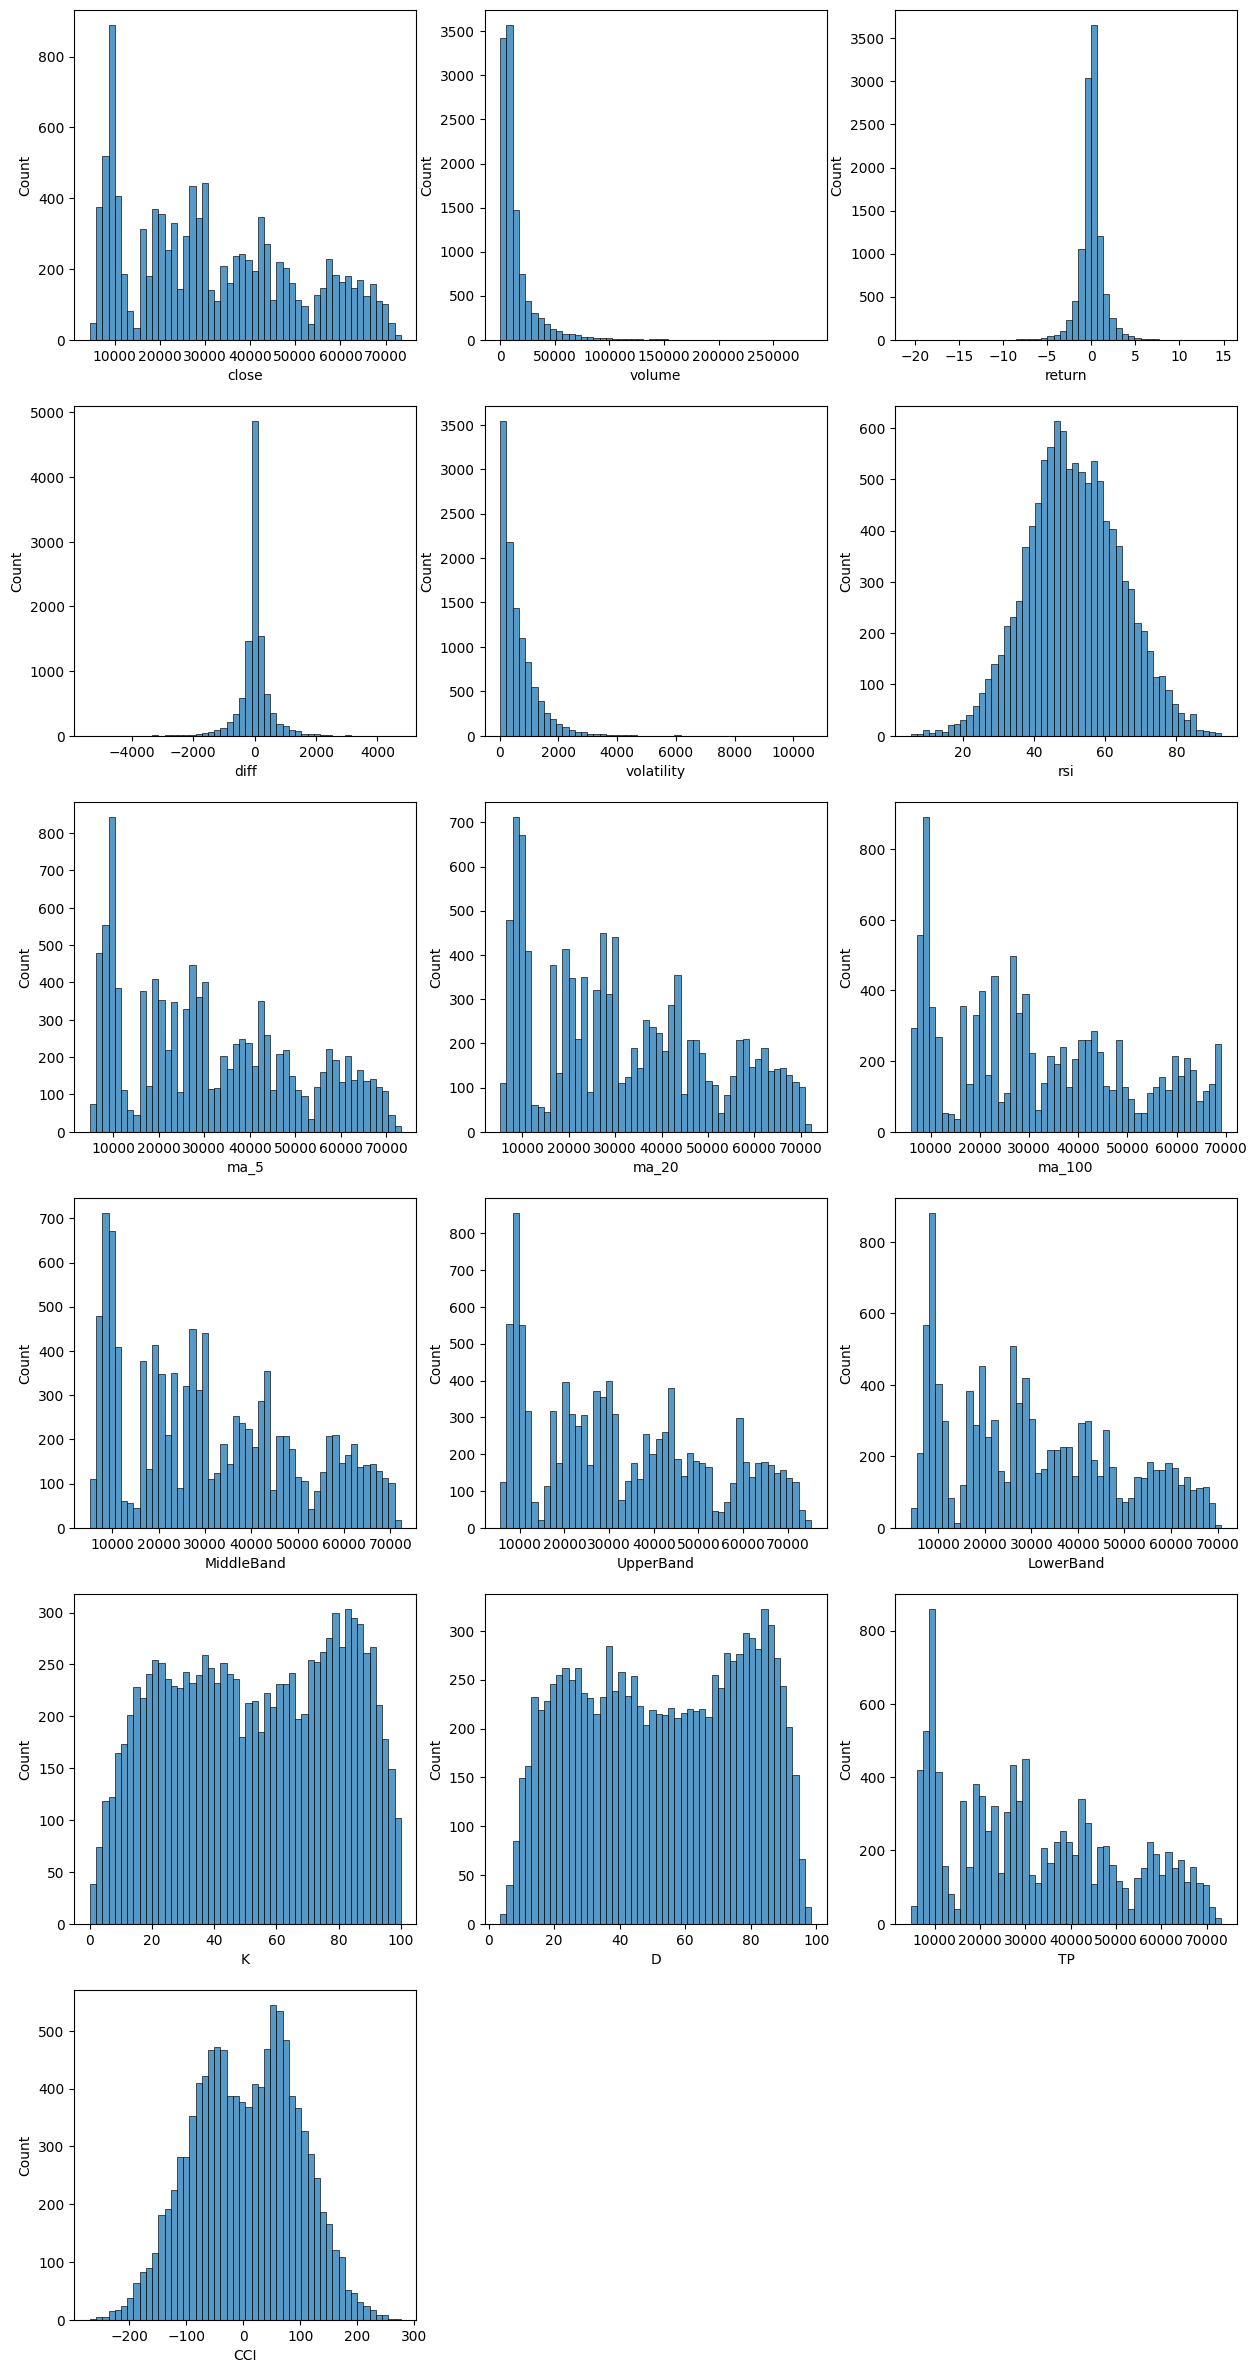

In [33]:
from Scripts.funciones import graficar_histogramas
df_numeric = df_4h.select_dtypes(include=[np.number])
hist = graficar_histogramas(df_numeric,df_numeric.columns)

## 1.1 Correlation of the features

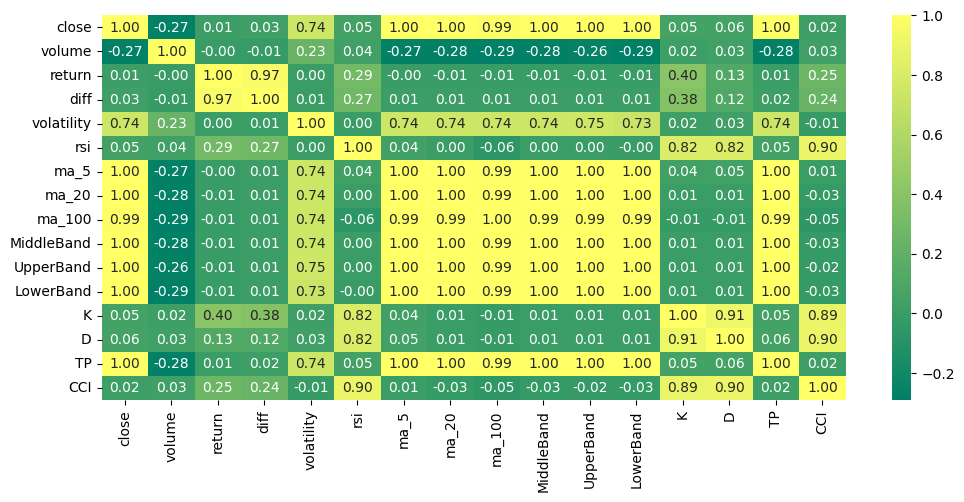

In [32]:
plt.figure(figsize=(12,5))
sns.heatmap(df_numeric.corr(method='spearman'),annot=True,fmt='.2f',cmap='summer')
plt.show()